In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy import linalg
from numba import njit
from scipy.interpolate import interp1d


On s'intéresse à approximer la solution de l'équation de transport suivante:
\begin{equation}
    \begin{cases}
    & \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \epsilon \frac{\partial^2 u}{\partial x^2}+f(x,t) \quad \text{pour} \quad t > 0, \quad x \in [l, L]\\
    & u(x,0)=u_0(x) \quad \forall x \in [l,L]
    \end{cases}
\end{equation}
<span style="color:red;">Premier cas:</span>

La solution exacte:
$$
u(x,t)=\alpha e^{-2\beta t} sin(2\pi x)
$$
$$ \Longrightarrow{} u_t = -2\alpha \beta e^{-2\beta t}sin(2\pi x)=-2\beta u$$
et 
$$ u_x = 2 \pi \alpha e^{-2 \beta t} cos(2\pi x)$$
et 
$$ u_{xx} = -(2 \pi)^2 \alpha e^{-2 \beta t} sin(2\pi x)=-(2\pi )^2 u$$
Par suite:
\begin{align}
f(x,t) & = u_t+uu_x-\epsilon u_{xx} \\
& = (\epsilon (2 \pi)^2 - 2\beta ) u+ 2\pi \alpha u e^{-2\beta t} cos(2 \pi x) 
\end{align}

<span style="color:red;">Deuxieme cas:</span>
$$ 
u(t, x) = 
\begin{cases} 
tx & \text{if } 0 \leq x \leq 1 \\
t & \text{if } 1 \leq x \leq 3 \\
t(4 - x) & \text{if } 3 \leq x \leq 4
\end{cases}
$$
Ce qui implique:
$$ 
f(t, x) = 
\begin{cases} 
x+ut & \text{if } 0 \leq x \leq 1 \\
1 & \text{if } 1 \leq x \leq 3 \\
(4-x) -ut & \text{if } 3 \leq x \leq 4
\end{cases}
$$

In [5]:
#La Solution Exacte:
@njit(cache=True)
def u_exacte1(x,t, ALPHA, beta):
    return ALPHA * np.exp(-2 * beta * t) * np.sin(2 * np.pi * x)


@njit(cache=True)
def u_exacte2(x,t, ALPHA, beta):
    if x>= 0 and x<=1:
        return t*x
    elif x>1 and x<=3:
        return t
    elif x> 3:
        return t*(4-x)
    
#Le terme source
@njit(cache=True)
def f1(x, t, ALPHA, beta , epsilon):
    u  = ALPHA * np.exp(-2 * beta * t) * np.sin(2 * np.pi * x)
    A1 = epsilon * 4 * np.pi**2 - 2 * beta 
    A2 = 2*np.pi * ALPHA * u * np.exp(-2 * beta *t) * np.cos(2* np.pi *x)
    return A1 * u + A2


@njit(cache=True)
def f2(x, t, ALPHA, beta , epsilon):
    if x>= 0 and x<=1:
        u= t*x
    elif x>1 and x<=3:
        u= t
    elif x> 3:
        u= t*(4-x)
    
    
    if x>= 0 and x<=1:
        return x+u*t
    elif x>1 and x<=3:
        return 1
    elif x> 3:
        return (4-x) -u*t


@njit(cache=True)
def u0_Gauss(x):
    # Condition initiale gaussienne
    return np.sin(np.pi * x / (L - l)) + 2.5 * (L - l) * np.sin(100 * (L - l) * np.pi * x / (L - l))




# Le flux Exacte:
@njit
def F(u):
    return (u**2)/2

# Les Flux des schemas:
@njit
def Rusanov(ug,ud,dx,dt):
    lamda= max(abs(ug),abs(ud))
    return 0.5*(F(ug)+F(ud))-lamda*(ud-ug)

@njit
def Rusanov2(ug,ud,dx,dt):
    lamda= max(abs(ug),abs(ud))
    return 0.5*(F(ug)+F(ud)-lamda*(ud-ug))

@njit
def Roe(ug,ud,dx,dt):
    return 0.5 *( (F(ug)+F(ud)) - (ug+ud)/2 *(ud-ug) )
  
@njit
def LF(ug,ud,dx,dt):
    return 0.5 *( (F(ug)+F(ud)) - (dx/dt) *(ud-ug) )

@njit
def LFM(ug,ud,dx,dt):
    return 0.5 *( (F(ug)+F(ud)) - 0.5*(dx/dt) *(ud-ug) )

@njit
def LW(ug, ud, dx, dt):
    A = 0.5 * (ud + ug)
    return 0.5 * (F(ug) + F(ud) - (dt / dx) * A * (F(ud) - F(ug)))

@njit(cache=True)
def depature_fvc_flux(dt,alpha,x,u):
    aux=1
    eps=1e-9
    x0=0.5*(x[0]+x[1])   
    x1=x0
    xmp=x0
    while(aux>eps):
        deriv=np.interp(x0, x, u)
        x1=xmp-dt*alpha*deriv
        aux=np.abs(x0-x1)
        x0=x1
    if x0>x[1]:
        x0=x[1]
    if x0<x[0]:
        x0=x[0]    
    return x0 

 
@njit(cache=True)
def fvc_flux(u,x,dt,alpha):
    if Case == 1:
        f = f1
    elif Case == 2:
        f = f2
    
    Alpha = alpha
    x_car = depature_fvc_flux(dt, Alpha,x,  u)

    up   = np.interp(x_car, x, u)
    

    return 0.5 * up**2

@njit(cache=True)
def VFC(U0, T, epsilon, N,  alpha, dx, CFL,X):
    if Case == 1:
        f = f1
    elif Case == 2:
        f = f2
        
    Un    = U0.copy()
    Unp1  = np.zeros(N)
    
    temps = 0
    

    
    while temps < T:
        not_zero = False
        for k in range(N):
            if Un[k] != 0:
                not_zero = True
                break
                
        if epsilon != 0 and not_zero:
            
            dt1  = CFL * (dx/(np.max(np.abs(Un))*np.sqrt(2*alpha)))
            dt2  = CFL * 0.5 * dx**2 / np.abs(epsilon)
            dt  = min(dt1,dt2)
        elif epsilon == 0 :
            dt  = CFL * (dx/(np.max(np.abs(Un))*np.sqrt(2*alpha)))
        elif [Un[k]==0 for k in range(N)]:
            dt  = CFL * 0.5 * dx**2 / np.abs(epsilon)
        elif [Un[k]==0 for k in range(N)] and epsilon == 0:
            dt  = 1e-2
                
        temps += min(dt,T-dt)
        
        for i in range(1,N-1):
            X1   = [X[i-1],X[i]]
            u1   = [Un[i-1],Un[i]]
            
            X2   = [X[i],X[i+1]]
            u2   = [Un[i],Un[i+1]]
            
            Fg  = fvc_flux(u1,X1,dt,alpha)
            Fd  = fvc_flux(u2,X2,dt,alpha)
            
            
            Unp1[i]=Un[i]-dt/dx*(Fd-Fg) + epsilon * (dt / (dx**2)) * (Un[i + 1] - 2 * Un[i] + Un[i - 1])+  dt  * f(X[i], temps, ALPHA, beta , epsilon )   
            
            
        Unp1[0]   = 0#Unp1[1]
        Unp1[N-1] = 0#Unp1[N-2]
        Un = Unp1.copy()
    return Un



@njit(cache=True)
def Solver ( U0, T, epsilon, N, dx, CFL, scheme ):
    if Case == 1:
        f = f1
    elif Case == 2:
        f = f2
    if scheme == 0:
        flux = Roe 
    elif scheme == 1:
        flux = Rusanov
    elif scheme == 2:
        flux = Rusanov2
    elif scheme == 3:
        flux = LF
    elif scheme == 4:
        flux = LFM
    elif scheme == 5:
        flux = LW
    

    Un = U0.copy()
    Unp1 = np.zeros(N)
    temps = 0
    while temps < T:
        not_zero = False
        for k in range(N):
            if Un[k] != 0:
                not_zero = True
                break
                
        
        #####################################################################################################
        ## Roe ##
        if scheme == 0 :
            if epsilon != 0 and not_zero:
                dt  = CFL /(max(np.abs(Un))/dx + 2 * np.abs(epsilon)/(dx**2))
            elif epsilon == 0:
                dt  = CFL *(dx / max(np.abs(Un)))
            elif [Un[k]==0 for k in range(N)]:
                dt  = CFL * 0.5 * dx**2 / np.abs(epsilon)
               
            
        ### LF  ##
        if scheme == 3:
            if epsilon != 0 and not_zero:
                dt  = CFL /(np.abs(0.5*max(Un)/dx -epsilon/(dx**2)))
            elif epsilon == 0:
                dt  = CFL *(dx / max(np.abs(Un)))
            elif [Un[k]==0 for k in range(N)]:
                dt  = CFL * 0.5 * dx**2 / np.abs(epsilon)
               

        ###  LFM ##
        if scheme == 4:
            if epsilon != 0 and not_zero:
                dt  =  CFL /(np.abs(0.5*max(Un)/dx -epsilon/(dx**2)))
            elif epsilon == 0:
                dt  = 0.5 * CFL *(dx / max(np.abs(Un)))
            elif [Un[k]==0 for k in range(N)]:
                dt  = CFL * 0.5 * dx**2 / np.abs(epsilon)
               

        ###  Rusanov ##
        if scheme == 1:
            if epsilon != 0 and not_zero:
                dt  = 0.5 * CFL *(dx / max(np.abs(Un)))
            elif [Un[k]==0 for k in range(N)]:
                dt  = CFL * 0.5 * dx**2 / np.abs(epsilon)
               
        
        ###  Rusanov2 ##
        if scheme == 2:
            if epsilon != 0 and not_zero:
                dt  =   CFL *(dx / max(np.abs(Un)))
            elif [Un[k]==0 for k in range(N)]:
                dt  = CFL * 0.5 * dx**2 / np.abs(epsilon)
               
                
        ###  Rusanov2 ##
        if scheme == 5:
            if epsilon != 0 and not_zero:
                dt1 =  CFL*dx/max(np.abs(Un))
                dt2 =  CFL * 0.5 * dx**2 / np.abs(epsilon)
                dt  =  min(dt1,dt2)  
            elif epsilon == 0: 
                dt =  CFL*dx/max(np.abs(Un))
            elif [Un[k]==0 for k in range(N)]:
                dt  = CFL * 0.5 * dx**2 / np.abs(epsilon)
               
        #####################################################################################################
        
        temps += min(dt,T-dt)
        for i in range(1,N-1):
            Fd = flux(Un[i],Un[i+1],dx,dt)
            Fg = flux(Un[i-1],Un[i],dx,dt)
            Unp1[i] = Un[i]-dt/dx*(Fd-Fg)+ epsilon * (dt / (dx**2)) * (Un[i + 1] - 2 * Un[i] + Un[i - 1])+  dt  * f(X[i], temps, ALPHA, beta , epsilon )   
            

        Unp1[0] = 0#Unp1[1]
        Unp1[N-1] = 0#Unp1[N-2]


        Un = Unp1.copy()
        

    return Un



###################################################################################
Case     =  2      #premier cas / 2eme cas
T        =  1
l        =  0

if Case == 1:
    L = 1
    u_exacte = u_exacte1
elif Case == 2 :
    L = 4
    u_exacte = u_exacte2

epsilon  =  1e-2
N        =  101
CFL      =  0.4
alpha    =  0.5

beta     =  1/2
ALPHA    =  2

X        =  np.linspace(l,L,N)
dx       =  (L-l)/(N-1)
U0       =  np.array([u_exacte(x, 0 , ALPHA, beta) for x in X])

results = {}

fluxes = {("Roe",0):1, ("Rusanov",1):1, ("Rusanov2",2):1, ("LW",5):1}

for i,j in fluxes.items():  
    if j:
        results[i[0]]  =  Solver  (U0, T, epsilon, N, dx, CFL, i[1])   
    
U_VFC = VFC(U0, T, epsilon, N,  alpha, dx, CFL,X)

results["VFC"]=U_VFC


/tmp/ipykernel_37526/3983418614.py:266: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for i in range(1,N-1):
/tmp/ipykernel_37526/3983418614.py:174: NumbaWarning: Cannot cache compiled function "Solver" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  @njit(cache=True)


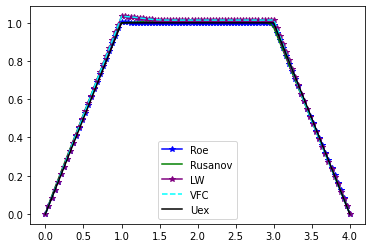

In [6]:
PLOT = {"Roe":1, "Rusanov":1, "Rusanov2":0, "LW":1,"VFC":1 }

colors = ['blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'brown']

symbols = ['-*', '-', '-+', '-*', '--', '-', '--', '--']

for i, (flux, Un) in enumerate(results.items()) :
    k = list(PLOT)[i]
    if PLOT[k]:
        plt.plot(X, Un, list(symbols)[i], label=flux, color=colors[i])
    
UExact = np.array([u_exacte(x,T,ALPHA,beta) for x in X])

plt.plot(X, UExact, '-k',  label='Uex')
        
        

#plt.xlim([0.4, 0.6])  
#plt.ylim([-0.5, 0.5])  

plt.legend()
plt.pause(0.1)


In [7]:
Errors = {}
for i, (flux, Un) in enumerate(results.items()):
    Errors[flux]    =  np.linalg.norm(Un-UExact,ord = 2)
Errors

{'Roe': 0.06490588595129769,
 'Rusanov': 0.12714164332432887,
 'Rusanov2': 0.5798015143713976,
 'LW': 0.16432976535670776,
 'VFC': 0.1644140012062004}